In [2]:
import pandas as pd
import numpy as np

# === 1) Source workbook ===
src = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis.xlsx"

# === 2) Robust Bloomberg parser (handles duplicate headers & Excel-serial dates) ===
def parse_bbg_sheet(df_raw, out_col):
    # find header row with both 'Dates' and 'PX_LAST' (case-insensitive)
    header_row = None
    for i, row in df_raw.iterrows():
        vals = row.astype(str).str.strip().str.upper()
        if ('DATES' in vals.values) and ('PX_LAST' in vals.values):
            header_row = i
            break
    if header_row is None:
        raise ValueError("Could not find 'Dates'/'PX_LAST' header row.")

    df = df_raw.iloc[header_row:].copy()
    df.columns = df.iloc[0]
    df = df.iloc[1:].copy()

    # drop duplicate columns
    df = df.loc[:, ~df.columns.duplicated()]
    df.rename(columns={c: str(c).strip() for c in df.columns}, inplace=True)

    # pick date & px columns (tolerate suffixes)
    date_candidates = [c for c in df.columns if c.lower().startswith('dates') or c.lower()=='date']
    px_candidates   = [c for c in df.columns if c.upper().startswith('PX_LAST')]
    if not date_candidates or not px_candidates:
        raise ValueError(f"Missing date/px columns. Columns: {list(df.columns)}")

    date_col, px_col = date_candidates[0], px_candidates[0]
    df = df[[date_col, px_col]].copy()
    df.columns = ['Dates', out_col]

    # parse dates; fallback to Excel serial
    dates_parsed = pd.to_datetime(df['Dates'], errors='coerce')
    mask = dates_parsed.isna()
    if mask.any():
        as_num = pd.to_numeric(df.loc[mask, 'Dates'], errors='coerce')
        if as_num.notna().any():
            dates_parsed.loc[mask & as_num.notna()] = pd.to_datetime('1899-12-30') + pd.to_timedelta(as_num.dropna(), unit='D')

    df['Dates'] = dates_parsed
    df[out_col] = pd.to_numeric(df[out_col], errors='coerce')
    df = df.dropna(subset=['Dates']).set_index('Dates').sort_index()
    return df

# === 3) Find the correct daily/weekly sheet names automatically ===
with pd.ExcelFile(src, engine="openpyxl") as xl:
    sheet_names = [s for s in xl.sheet_names]  # keep original
    lname = [s.lower() for s in sheet_names]

    def find_sheet(words):
        # words: list of substrings that must all appear (case-insensitive)
        for s, ls in zip(sheet_names, lname):
            if all(w in ls for w in words):
                return s
        return None

    # Try common patterns for Swiss Gov Bonds
    daily_sheet  = find_sheet(['gov', 'daily'])  or find_sheet(['bond', 'daily'])  or find_sheet(['swiss', 'gov', 'daily'])
    weekly_sheet = find_sheet(['gov', 'weekly']) or find_sheet(['bond', 'weekly']) or find_sheet(['swiss', 'gov', 'weekly'])

    if daily_sheet is None or weekly_sheet is None:
        raise ValueError(f"Could not find Gov Bond sheets.\nAvailable: {sheet_names}")

    gb_d_raw = xl.parse(daily_sheet,  header=None)
    gb_w_raw = xl.parse(weekly_sheet, header=None)

# === 4) Parse + compute log returns ===
gb_d = parse_bbg_sheet(gb_d_raw, "GovBond_CHF_Last")
gb_w = parse_bbg_sheet(gb_w_raw, "GovBond_CHF_Last")

gb_d['GovBond_ret'] = np.log(gb_d['GovBond_CHF_Last']).diff()
gb_w['GovBond_ret'] = np.log(gb_w['GovBond_CHF_Last']).diff()

gb_d = gb_d.dropna(subset=['GovBond_ret'])
gb_w = gb_w.dropna(subset=['GovBond_ret'])

# === 5) Save tidy outputs with standard sheet names (as in your Real Estate file) ===
out = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GovBondCHF_returns.xlsx"
with pd.ExcelWriter(out, engine='openpyxl') as writer:
    gb_d.to_excel(writer, sheet_name="GovBondCHF daily + ret")
    gb_w.to_excel(writer, sheet_name="GovBondCHF weekly + ret")

print("✅ Government Bonds (CHF) returns saved to:", out)
print("Detected sheets → Daily:", daily_sheet, "| Weekly:", weekly_sheet)


✅ Government Bonds (CHF) returns saved to: C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GovBondCHF_returns.xlsx
Detected sheets → Daily: GovernmentBondCHF daily | Weekly: GovernmentBondCHF weekly


=== Daily Government Bond Log Returns (CHF) ===
count    2557.000000
mean       -0.000055
std         0.004211
min        -0.021416
25%        -0.002341
50%         0.000000
75%         0.002313
max         0.023079
Name: GovBond_ret, dtype: float64

=== Weekly Government Bond Log Returns (CHF) ===
count    530.000000
mean      -0.000276
std        0.008608
min       -0.033109
25%       -0.005491
50%        0.000000
75%        0.004434
max        0.037741
Name: GovBond_ret, dtype: float64


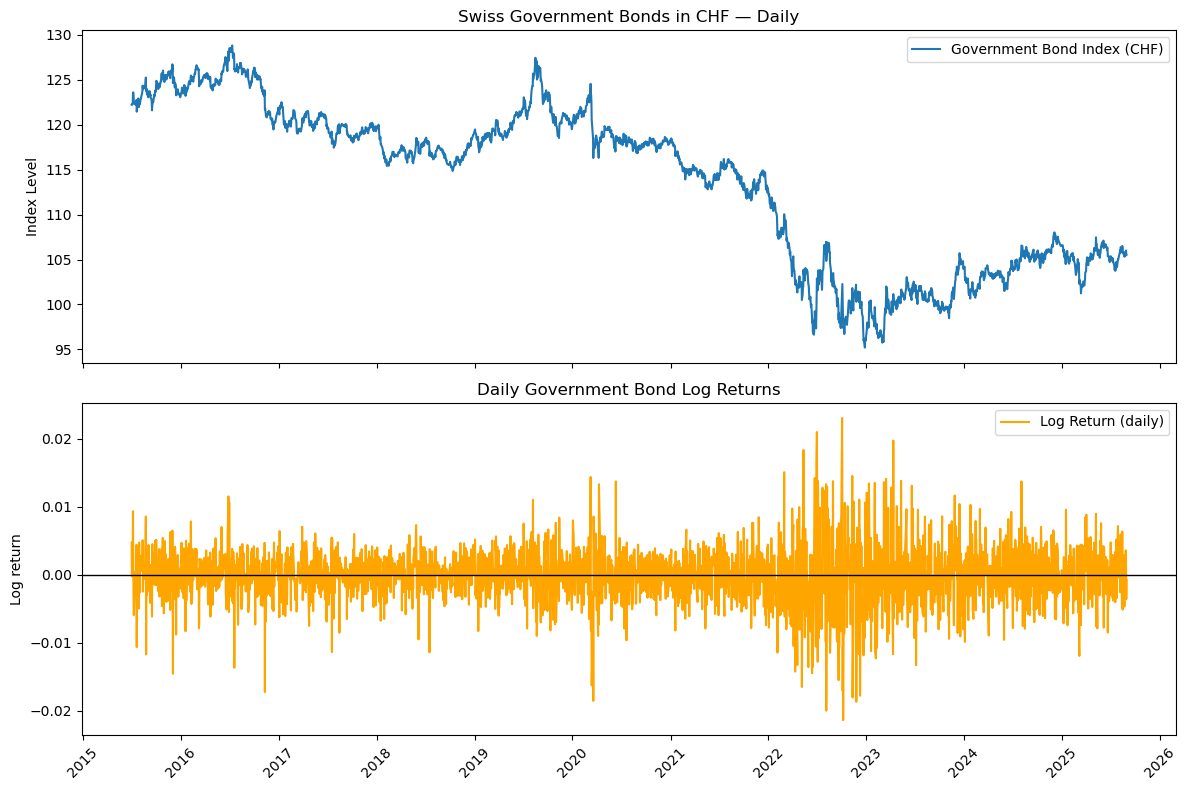

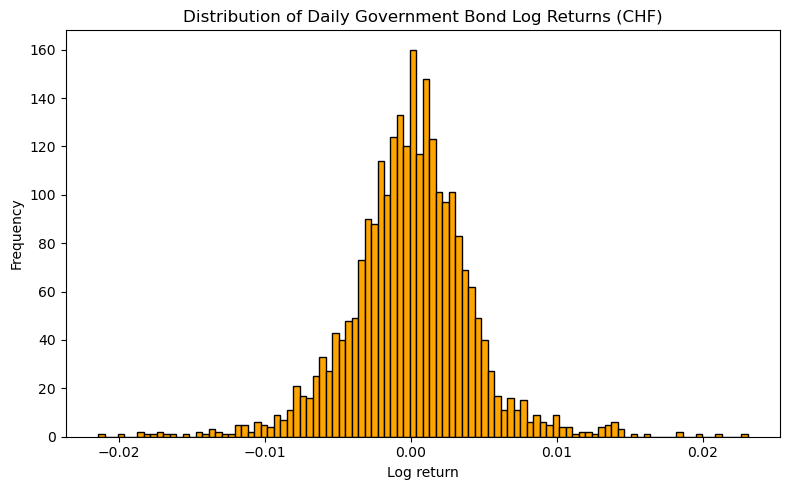

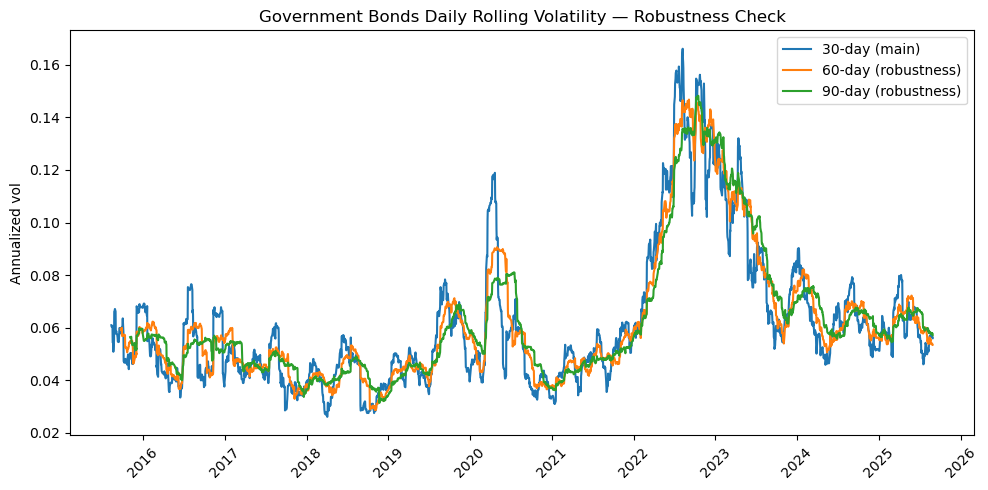

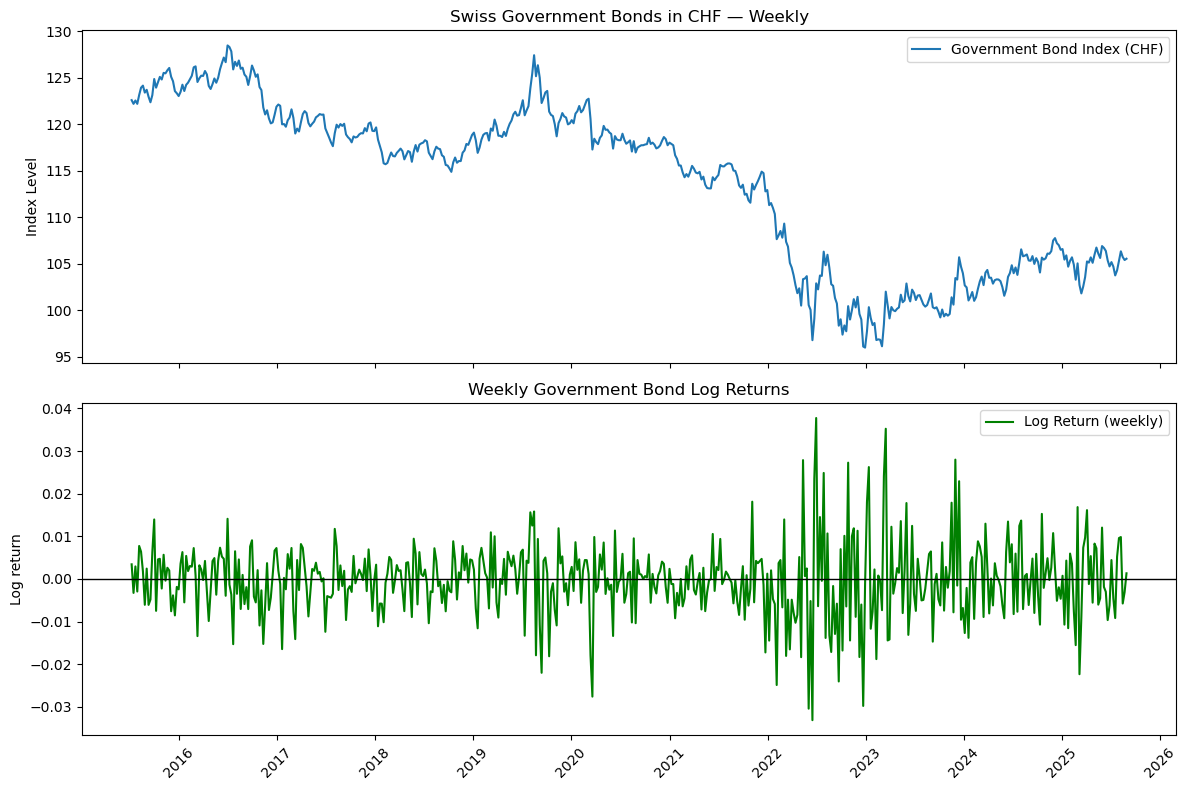

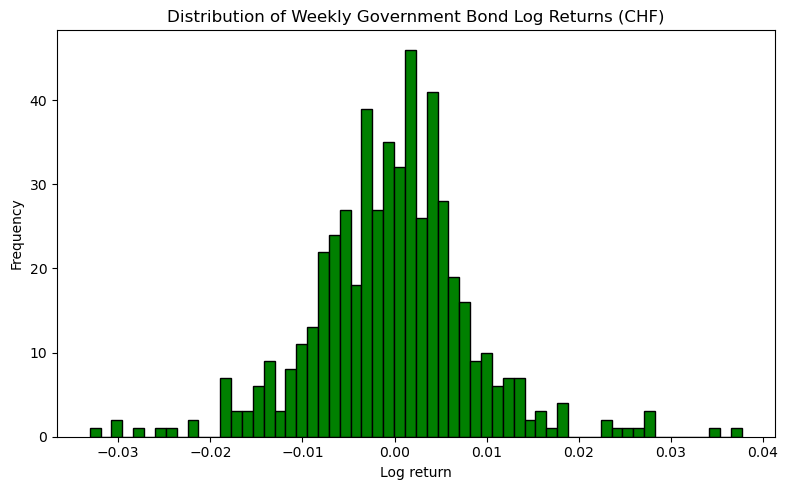

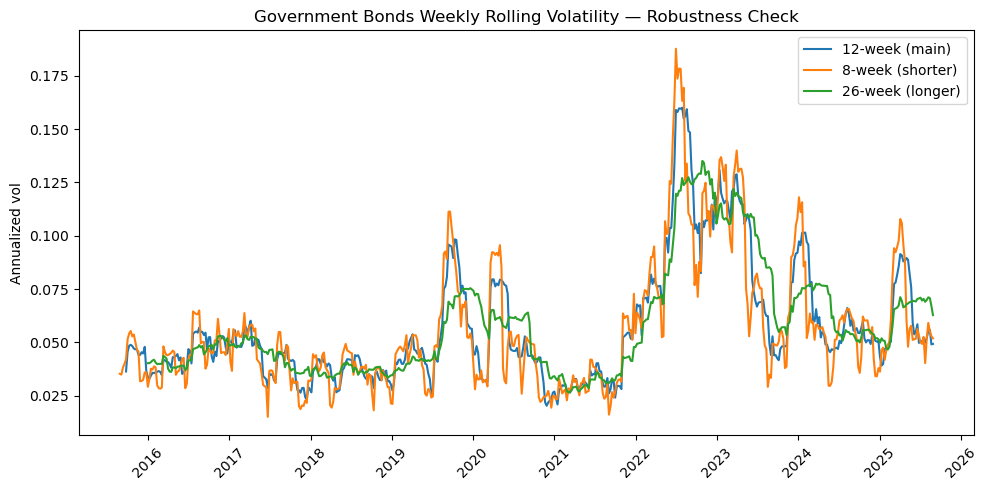

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1) Load saved Gov Bond returns ===
path = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_GovBondCHF_returns.xlsx"
gb_d = pd.read_excel(path, sheet_name="GovBondCHF daily + ret", index_col=0, parse_dates=True)
gb_w = pd.read_excel(path, sheet_name="GovBondCHF weekly + ret", index_col=0, parse_dates=True)

# === 2) Descriptive statistics ===
print("=== Daily Government Bond Log Returns (CHF) ===")
print(gb_d['GovBond_ret'].describe())
print("\n=== Weekly Government Bond Log Returns (CHF) ===")
print(gb_w['GovBond_ret'].describe())

# === Helper to format x-axis with years ===
def set_year_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# === 3) Daily: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(gb_d.index, gb_d['GovBond_CHF_Last'], label='Government Bond Index (CHF)')
ax[0].set_title('Swiss Government Bonds in CHF — Daily')
ax[0].set_ylabel('Index Level'); ax[0].legend(); set_year_axis(ax[0])

ax[1].plot(gb_d.index, gb_d['GovBond_ret'], color='orange', label='Log Return (daily)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Daily Government Bond Log Returns')
ax[1].set_ylabel('Log return'); ax[1].legend(); set_year_axis(ax[1])
plt.tight_layout(); plt.show()

# === 4) Daily histogram ===
plt.figure(figsize=(8,5))
plt.hist(gb_d['GovBond_ret'].dropna(), bins=100, color='orange', edgecolor='black')
plt.title('Distribution of Daily Government Bond Log Returns (CHF)')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 5) Daily rolling vol (30d main) + robustness (60/90d), annualized √252 ===
gb_d['RollingVol30'] = gb_d['GovBond_ret'].rolling(30).std()
gb_d['RollingVol60'] = gb_d['GovBond_ret'].rolling(60).std()
gb_d['RollingVol90'] = gb_d['GovBond_ret'].rolling(90).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(gb_d.index, gb_d['RollingVol30'] * np.sqrt(252), label='30-day (main)')
ax.plot(gb_d.index, gb_d['RollingVol60'] * np.sqrt(252), label='60-day (robustness)')
ax.plot(gb_d.index, gb_d['RollingVol90'] * np.sqrt(252), label='90-day (robustness)')
ax.set_title('Government Bonds Daily Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol'); ax.legend(); set_year_axis(ax)
plt.tight_layout(); plt.show()

# === 6) Weekly: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(gb_w.index, gb_w['GovBond_CHF_Last'], label='Government Bond Index (CHF)')
ax[0].set_title('Swiss Government Bonds in CHF — Weekly')
ax[0].set_ylabel('Index Level'); ax[0].legend(); set_year_axis(ax[0])

ax[1].plot(gb_w.index, gb_w['GovBond_ret'], color='green', label='Log Return (weekly)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Weekly Government Bond Log Returns')
ax[1].set_ylabel('Log return'); ax[1].legend(); set_year_axis(ax[1])
plt.tight_layout(); plt.show()

# === 7) Weekly histogram ===
plt.figure(figsize=(8,5))
plt.hist(gb_w['GovBond_ret'].dropna(), bins=60, color='green', edgecolor='black')
plt.title('Distribution of Weekly Government Bond Log Returns (CHF)')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 8) Weekly rolling vol (12w main) + robustness (8/26w), annualized √52 ===
gb_w['RollingVol12w'] = gb_w['GovBond_ret'].rolling(12).std()
gb_w['RollingVol8w']  = gb_w['GovBond_ret'].rolling(8).std()
gb_w['RollingVol26w'] = gb_w['GovBond_ret'].rolling(26).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(gb_w.index, gb_w['RollingVol12w'] * np.sqrt(52), label='12-week (main)')
ax.plot(gb_w.index, gb_w['RollingVol8w']  * np.sqrt(52), label='8-week (shorter)')
ax.plot(gb_w.index, gb_w['RollingVol26w'] * np.sqrt(52), label='26-week (longer)')
ax.set_title('Government Bonds Weekly Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol'); ax.legend(); set_year_axis(ax)
plt.tight_layout(); plt.show()
